# Segmenting and Clustering Neighborhoods in Toronto

Import libraries

In [2]:
import requests
import pandas as pd
import bs4 
from bs4 import BeautifulSoup

Get data

In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
data = BeautifulSoup(url,'lxml')

Convert content of PostalCode HTML table as dataframe

In [4]:
data_table = data.find('table', class_ = 'wikitable')
table_rows = data_table.find_all('tr')

n = []
for row in table_rows:
    info = row.text.split('\n')[1:-1] 
    n.append(info)

In [5]:
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(n[1:], columns = column_names)
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


# Data Cleaning

In [6]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) ]
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


Group neighborhood by Postcode

In [7]:
group = df.groupby('Postalcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postalcode', 'Borough', 'Neighborhood']

grouped_df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
grouped_df.shape

(103, 3)

Load and transfer the csv file into dataframe

In [9]:
coord_df = pd.read_csv('Geospatial_Coordinates.csv') 

print('The shape of coordinates dataframe is', coord_df.shape)
coord_df.head()

The shape of coordinates dataframe is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
df2 = grouped_df.join(coord_df.set_index('Postal Code'), on='Postalcode')#Combine into 1 dataframe :D

df2.head(12)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [11]:
df2.shape

(103, 5)

# Part 2

Generate a map indicates the coordinates of postalcode in Toronto

In [12]:
import folium
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in df2.itertuples(): 
    label = 'Postalcode: {};  Borough: {};  Neighborhood: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

As we can see there are overlaps on the map, generate another graph to avoid misrepresenting.

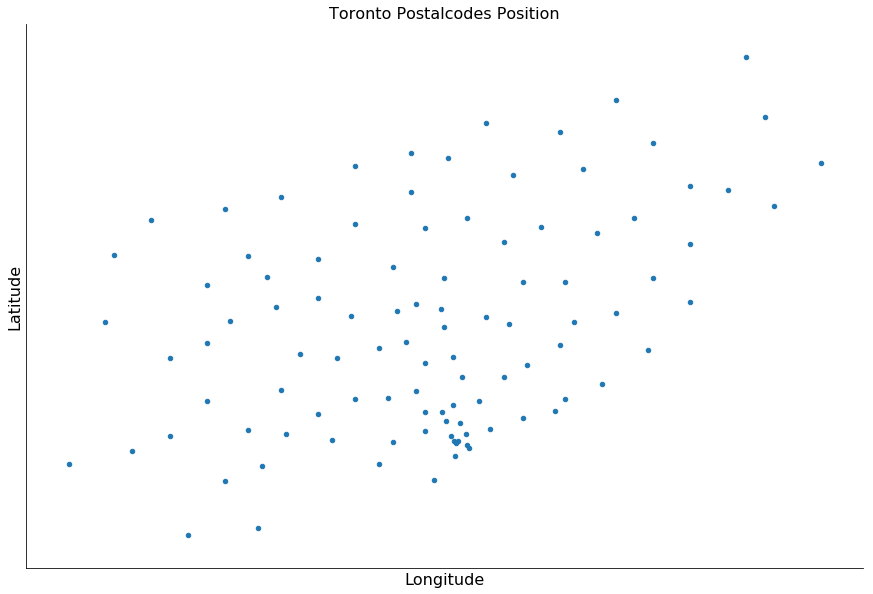

In [15]:
import matplotlib.pyplot as plt

X = df2[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postalcodes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [16]:
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

Create a new data frame with borough = Scarborough

In [26]:
CLIENT_ID = 'STMX202ELDKLXE2O5LOC4L0UDMVUFMFSOP3J5IAQ21BGFER1' 
CLIENT_SECRET = 'JDBNYKZWNVWYI45GYW343KB130YS31EG4TLQ34EI2THXXSAG' 
VERSION = '20180604'

In [25]:
scarborough_data = df2[df2['Borough'] == 'Scarborough'].reset_index(drop=True)
scarborough_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Get a map of Scarborough and its neighborhood

In [27]:
address_scar = 'Scarborough,Toronto'
latitude_scar = 43.773077
longitude_scar = -79.257774
print('The geograpical coordinate of Scarborough are {}, {}.'.format(latitude_scar, longitude_scar))

The geograpical coordinate of Scarborough are 43.773077, -79.257774.


In [29]:
map2 = folium.Map(location=[latitude_scar, longitude_scar], zoom_start=12)


for lat, lng, label in zip(scarborough_data['Latitude'], scarborough_data['Longitude'], scarborough_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_scarb)  
    
map2

Get venues in neighborhood 'Woburn' from Scarborogh

In [32]:
neighborhood_latitude = scarborough_data.loc[3, 'Latitude'] 
neighborhood_longitude = scarborough_data.loc[3, 'Longitude'] 

neighborhood_name = scarborough_data.loc[3, 'Neighborhood']

print('Latitude and longitude values of "{}" are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of "Woburn" are 43.7709921, -79.21691740000001.


In [33]:
LIMIT = 100 # foursquare
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_scar, longitude_scar, VERSION, radius, LIMIT)

In [36]:
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

In [37]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
import json 
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']  
nearby_venues = json_normalize(venues) 


filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(15)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,American Eagle Outfitters,Clothing Store,43.775908,-79.258352
3,Tommy Hilfiger Company Store,Clothing Store,43.776015,-79.257369
4,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
5,DAVIDsTEA,Tea Room,43.776613,-79.258516
6,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069
7,Coliseum Scarborough Cinemas,Movie Theater,43.775995,-79.255649
8,Hot Topic,Clothing Store,43.775450,-79.257929
9,Tim Hortons,Coffee Shop,43.769936,-79.260368


In [40]:
nearby_venues.shape[0] # get the number of venues found in this neibourhood

45

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues for each neighborhood in scarborogh

In [44]:
scarborough_venues = getNearbyVenues(names=scarborough_data['Neighborhood'],
                                   latitudes=scarborough_data['Latitude'],
                                   longitudes=scarborough_data['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge


In [45]:
scarborough_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [46]:
scarborough_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Birch Cliff, Cliffside West",5,5,5,5,5,5
Cedarbrae,7,7,7,7,7,7
"Clairlea, Golden Mile, Oakridge",9,9,9,9,9,9
"Clarks Corners, Sullivan, Tam O'Shanter",10,10,10,10,10,10
"Cliffcrest, Cliffside, Scarborough Village West",3,3,3,3,3,3
"Dorset Park, Scarborough Town Centre, Wexford Heights",6,6,6,6,6,6
"East Birchmount Park, Ionview, Kennedy Park",6,6,6,6,6,6


In [47]:
print('There are {} uniques categories.'.format(len(scarborough_venues['Venue Category'].unique())))

There are 52 uniques categories.


In [48]:
scarb_onehot = pd.get_dummies(scarborough_venues[['Venue Category']], prefix="", prefix_sep="")


scarb_onehot['Neighborhood'] = scarborough_venues['Neighborhood'] 


fixed_columns = [scarb_onehot.columns[-1]] + list(scarb_onehot.columns[:-1])
scarb_onehot = scarb_onehot[fixed_columns]

scarb_onehot.head()

,Neighborhood,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,...,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Spa,Thai Restaurant,Thrift / Vintage Store,Vietnamese Restaurant
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
scarb_onehot.shape

(86, 53)

In [50]:
scarb_grouped = scarb_onehot.groupby('Neighborhood').mean().reset_index()
scarb_grouped.head()

,Neighborhood,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,...,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Spa,Thai Restaurant,Thrift / Vintage Store,Vietnamese Restaurant
0,Agincourt,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.2,0.000000,0.000000,...,0.0,0.0,0.2,0.0,0.2,0.000000,0.0,0.000000,0.0,0.0
1,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,"Birch Cliff, Cliffside West",0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.000000,0.0,0.0
3,Cedarbrae,0.0,0.142857,0.0,0.142857,0.142857,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0
4,"Clairlea, Golden Mile, Oakridge",0.0,0.000000,0.0,0.222222,0.000000,0.0,0.0,0.222222,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0


## Get top 10 venues for each neighborhood

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = scarb_grouped['Neighborhood']

for ind in np.arange(scarb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(scarb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Sandwich Place,Breakfast Spot,Chinese Restaurant,Vietnamese Restaurant,College Stadium,General Entertainment,Fried Chicken Joint,Fast Food Restaurant
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store,Discount Store
2,"Birch Cliff, Cliffside West",General Entertainment,Skating Rink,Farm,Café,College Stadium,Vietnamese Restaurant,Coffee Shop,Grocery Store,Fried Chicken Joint,Fast Food Restaurant
3,Cedarbrae,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Grocery Store,General Entertainment
4,"Clairlea, Golden Mile, Oakridge",Bakery,Bus Line,Intersection,Soccer Field,Fast Food Restaurant,Bus Station,Metro Station,Convenience Store,Grocery Store,General Entertainment


## Clustering

In [57]:
from sklearn.cluster import KMeans

scarb_data = scarborough_data.drop(16)

k = 5

scarb_grouped_clustering = scarb_grouped.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=k, random_state=0).fit(scarb_grouped_clustering)


kmeans.labels_[:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

Combine kmeans to the data frame.

In [59]:
scarb_merged = scarb_data


scarb_merged['Cluster Labels'] = kmeans.labels_

scarb_merged = scarb_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

scarb_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Vietnamese Restaurant,Thrift / Vintage Store,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Farm,Electronics Store,Discount Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Bar,Vietnamese Restaurant,College Stadium,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Intersection,Electronics Store,Breakfast Spot,Rental Car Location,Medical Center,Pizza Place,Mexican Restaurant,College Stadium,General Entertainment,Fried Chicken Joint
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Indian Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store,Discount Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Grocery Store,General Entertainment


## Visualize on map

In [63]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location = [latitude_scar, longitude_scar], zoom_start=11)


x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(scarb_merged['Latitude'], scarb_merged['Longitude'], scarb_merged['Neighborhood'], scarb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine each five of the clusters

In [64]:
scarb_merged.loc[scarb_merged['Cluster Labels'] == 0, scarb_merged.columns[[1] + list(range(5, scarb_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,0,Bar,Vietnamese Restaurant,College Stadium,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store
14,Scarborough,0,Park,Playground,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store,Discount Store


In [65]:
scarb_merged.loc[scarb_merged['Cluster Labels'] == 1, scarb_merged.columns[[1] + list(range(5, scarb_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1,Fast Food Restaurant,Vietnamese Restaurant,Thrift / Vintage Store,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Farm,Electronics Store,Discount Store
2,Scarborough,1,Intersection,Electronics Store,Breakfast Spot,Rental Car Location,Medical Center,Pizza Place,Mexican Restaurant,College Stadium,General Entertainment,Fried Chicken Joint
3,Scarborough,1,Coffee Shop,Korean Restaurant,Indian Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store,Discount Store
4,Scarborough,1,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Grocery Store,General Entertainment
5,Scarborough,1,Spa,Playground,Convenience Store,Vietnamese Restaurant,Coffee Shop,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm
6,Scarborough,1,Discount Store,Coffee Shop,Bus Station,Department Store,Chinese Restaurant,College Stadium,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint
7,Scarborough,1,Bakery,Bus Line,Intersection,Soccer Field,Fast Food Restaurant,Bus Station,Metro Station,Convenience Store,Grocery Store,General Entertainment
8,Scarborough,1,American Restaurant,Motel,Movie Theater,College Stadium,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Farm,Electronics Store
9,Scarborough,1,General Entertainment,Skating Rink,Farm,Café,College Stadium,Vietnamese Restaurant,Coffee Shop,Grocery Store,Fried Chicken Joint,Fast Food Restaurant
11,Scarborough,1,Auto Garage,Bakery,Shopping Mall,Sandwich Place,Breakfast Spot,Middle Eastern Restaurant,Vietnamese Restaurant,College Stadium,General Entertainment,Fried Chicken Joint


In [66]:
scarb_merged.loc[scarb_merged['Cluster Labels'] == 2, scarb_merged.columns[[1] + list(range(5, scarb_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Scarborough,2,Pizza Place,Noodle House,Chinese Restaurant,Thai Restaurant,Fried Chicken Joint,Italian Restaurant,Fast Food Restaurant,Bank,Pharmacy,Farm


In [67]:
scarb_merged.loc[scarb_merged['Cluster Labels'] == 3, scarb_merged.columns[[1] + list(range(5, scarb_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Scarborough,3,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Thrift / Vintage Store,Nail Salon,Grocery Store,Sandwich Place,Breakfast Spot,Pizza Place,Pharmacy


In [68]:
scarb_merged.loc[scarb_merged['Cluster Labels'] == 4, scarb_merged.columns[[1] + list(range(5, scarb_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Scarborough,4,Indian Restaurant,Vietnamese Restaurant,Pet Store,Latin American Restaurant,Chinese Restaurant,Bank,Bar,Grocery Store,General Entertainment,Athletics & Sports
